## PCA

We're going to run PCA on efferent and afferent connectivity matrices, so we can look at differences between hippocampal afferent and efferent connectivity. We predict that connections to the hippocampus connect more or less equally across all subregions of the hippocampus, so we should see more principal components, each explaining less variance. Conversely, we predict that connections coming out of the hippocampus are more functionally specialized and thus we should see fewer principal components, with the first few explaining most of the variance--this is because outputs cluster in more distinct patterns (outputs really define the function of a region) and thus the variance in connectivity profiles can be defined by fewer clusters.

In [7]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from helpers import plot_incoming_outgoing_PCA, get_feature_vectors_shared

In [8]:
df_average = pd.read_csv('../data/average_connectome_data.csv', header=0, index_col=0)

In [9]:
# filter the afferent / efferent based on hippocampal connections, create similarity matrix
hippocampal_regions = np.array(['DG','CA3','CA2','CA1v','CA1d','SUBv','SUBd'])

# FROM hippocampus (efferent)
df_avg_from = df_average[df_average.index.isin(hippocampal_regions)]

# TO hippocampus (afferent)
df_average_t = df_average.T
df_avg_to = df_average_t[df_average_t.index.isin(hippocampal_regions)]

# drop HPC columns
df_avg_from = df_avg_from.drop(hippocampal_regions, axis=1)
df_avg_to = df_avg_to.drop(hippocampal_regions, axis=1)

# filter to only include columns and rows with at least one connection
df_avg_from = df_avg_from.loc[:,df_avg_from.apply(np.count_nonzero, axis=0) >= 1]
df_avg_to = df_avg_to.loc[:,df_avg_to.apply(np.count_nonzero, axis=0) >= 1]

# find the shared regions
common_cols = df_avg_to.columns.intersection(df_avg_from.columns)
df_avg_to_shared = df_avg_to[common_cols]
df_avg_from_shared = df_avg_from[common_cols]

In [10]:
df_avg_to_shared, df_avg_from_shared = get_feature_vectors_shared()

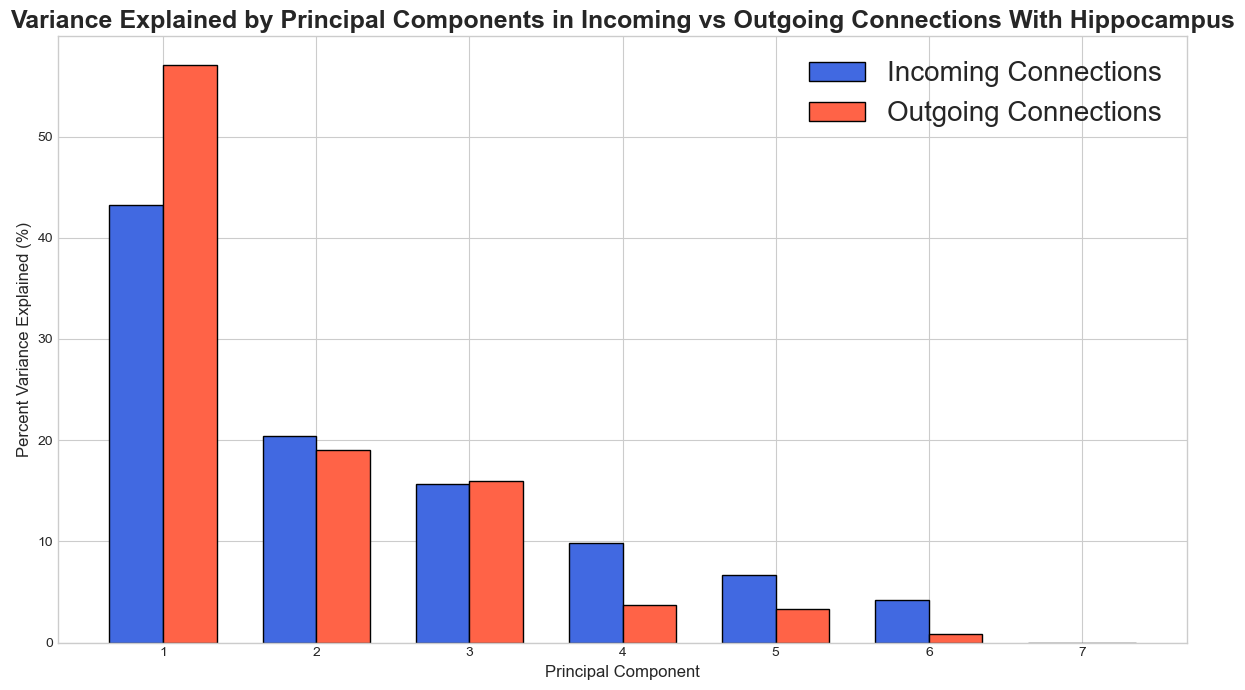

In [5]:
fig = plot_incoming_outgoing_PCA(incoming_distance = df_avg_to_shared,
                           outgoing_distance = df_avg_from_shared, 
                           n_components=7,
                           scale=True)

### Bootstrapping PCA

We want to know if the hippocampal principal components are unique or if they merely reflect more general network structure across the brain. We will boostrap 1000 simulations. For each trial:

- we randomly select 7 non-hippocampal regions and generate afferent/efferent matrices for those selected regions
- We run PCA on the afferent / efferent matrices
- Store PCA metrics in an array

In [30]:
variance_explained_A

array([3.77526912e+01, 2.17006048e+01, 1.71556173e+01, 9.12524918e+00,
       8.53520077e+00, 5.73063685e+00, 4.47286126e-31])

In [14]:
import random

# Assuming your inputs are:
# connectivity_matrix: numpy array of shape (392, 392)
# hippocampal_indices: list or array of 7 indices for hippocampal regions
# target_cols: list or array of 162 indices of the target regions (columns)

num_iterations = 2000

wb_variance_explained_afferent = np.zeros((num_iterations, 7))
wb_variance_explained_efferent = np.zeros((num_iterations, 7))

num_to_select = 7

# 1. Define all regions, exclude hippocampal regions
exclude_set = set(hippocampal_regions)
all_regions = df_average.index.to_numpy()

# 2. Create a list of candidates: strings in A that are NOT in the exclusion set
candidates = [region for region in all_regions if region not in exclude_set]

for i in range(num_iterations):
    # first grab 7 random non-hippocampal regions
    random_selection = random.sample(candidates, num_to_select)

    # construct afferent / efferent connection matrices from random regions
    # FROM random
    df_avg_from_random_sample = df_average[df_average.index.isin(random_selection)]
    
    # TO random
    df_average_t = df_average.T
    df_avg_to_random_sample = df_average_t[df_average_t.index.isin(random_selection)]
    
    # probably want to drop na columns and rows of all NaNs
    # spearman_df_from_random_sample = (df_avg_from_random_sample.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')
    # spearman_df_to_random_sample = (df_avg_to_random_sample.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')

    # Standardize the Data -- best to scale data before running PCA
    scaler = StandardScaler()
    afferent_scaled = scaler.fit_transform(df_avg_to_random_sample)
    efferent_scaled = scaler.fit_transform(df_avg_from_random_sample)
    
    # Perform PCA on Both Datasets
    # Since each dataset has 7 samples, there can be a maximum of 7 principal components.
    n_components = 7
    pca_afferent = PCA(n_components=n_components)
    pca_efferent = PCA(n_components=n_components)
    
    # Fit the PCA models to each dataset
    pca_afferent.fit(afferent_scaled)
    pca_efferent.fit(efferent_scaled)

    # store the outputs in arrays
    wb_variance_explained_afferent[i] = pca_afferent.explained_variance_ratio_ * 100
    wb_variance_explained_efferent[i] = pca_efferent.explained_variance_ratio_ * 100

In [15]:
# average variance explained across all 1000 iterations
average_afferent_variance_explained = np.mean(wb_variance_explained_afferent, axis=0)
average_efferent_variance_explained = np.mean(wb_variance_explained_efferent, axis=0)

In [16]:
average_afferent_variance_explained

array([3.65368458e+01, 2.28577140e+01, 1.58969066e+01, 1.15043166e+01,
       8.21274127e+00, 4.99147566e+00, 6.61514045e-30])

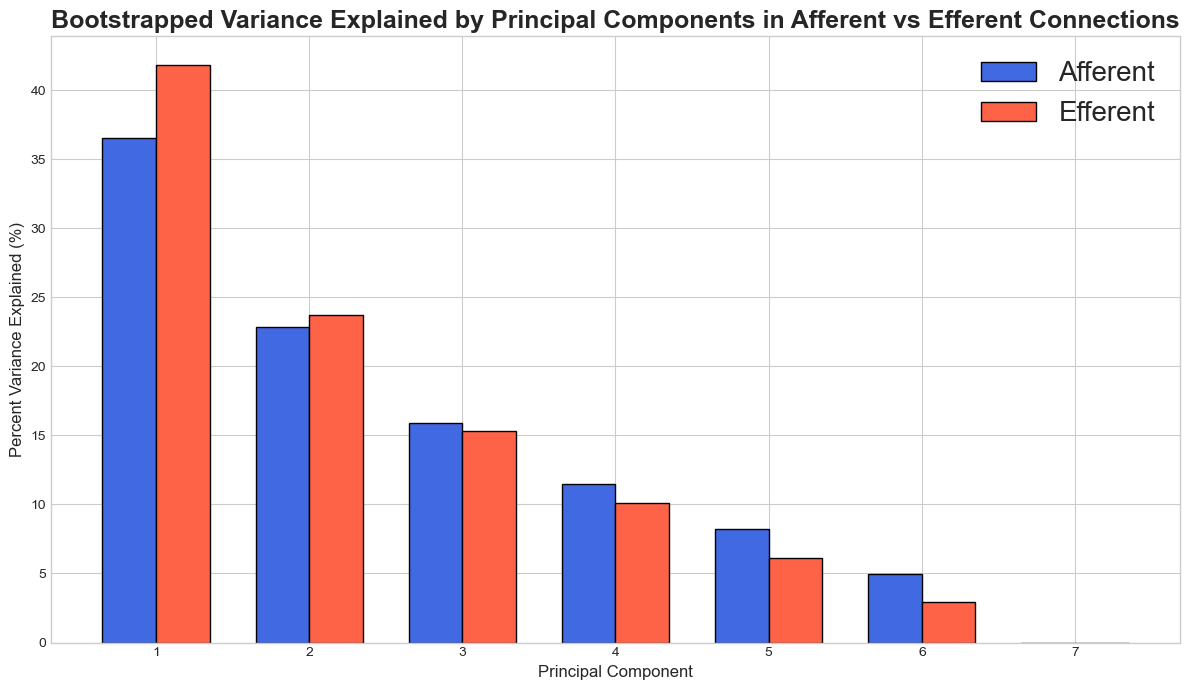

In [22]:
# plot the averages 

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Define the x-axis positions for the bars
component_numbers = np.arange(1, n_components + 1)
bar_width = 0.35

# Create the bar plot for Dataset A (Outgoing profiles)
ax.bar(
    component_numbers - bar_width/2,
    average_afferent_variance_explained,
    width=bar_width,
    label='Afferent',
    color='royalblue',
    edgecolor='k'
)

# Create the bar plot for Dataset B (Incoming profiles)
ax.bar(
    component_numbers + bar_width/2,
    average_efferent_variance_explained,
    width=bar_width,
    label='Efferent',
    color='tomato',
    edgecolor='k'
)


# Final Chart Formatting
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Percent Variance Explained (%)', fontsize=12)
ax.set_title('Bootstrapped Variance Explained by Principal Components in Afferent vs Efferent Connections', fontsize=18, weight='bold')
ax.set_xticks(component_numbers) # Ensure integer ticks for each component
ax.legend(fontsize=20)
plt.tight_layout()

plt.savefig('../output/PCA_bootstrapped_connectivity_profiles.png')
plt.show()

## Run Statistical Tests on Principal Components Between Efferent and Afferent

For the hippocampus efferent and afferent principal components, we find the difference between each component, which we will call the hippocampal connectivity component delta. Then we do the same for the bootstrapped values, which we will call whole brain connectivity component delta. 

Then we calculate the number of times in the bootstrapped values that the whole brain delta exceeds the hippocampal delta.

In [23]:
# difference in hippocampal principal components (efferent - afferent)
hippocampal_component_differences = hpc_variance_explained_efferent - hpc_variance_explained_afferent

whole_brain_component_differences = wb_variance_explained_efferent - wb_variance_explained_afferent

# Run PCA on Similarity Matrices

Next, we will run PCA on the similarity matrices generated from the feature vectors. It will be run on:

- afferent/efferent cosine similarity matrices using unique regions
- afferent/efferent cosine similarity matrices using shared regions
- repeat for spearman

In [12]:
# --- 1. First generate the distance matrices using cosine ---

# Unique regions
cosine_from_values = cosine_similarity(df_avg_from.T)
cosine_from_labels = df_avg_from.columns

cosine_df_from = pd.DataFrame(cosine_from_values, 
                             index=df_avg_from.columns, 
                             columns=df_avg_from.columns)

cosine_to_values = cosine_similarity(df_avg_to.T)
cosine_to_labels = df_avg_to.columns

cosine_df_to = pd.DataFrame(cosine_to_values, 
                             index=df_avg_to.columns, 
                             columns=df_avg_to.columns)

# Shared regions
cosine_from_shared_values = cosine_similarity(df_avg_from_shared.T)
cosine_from_shared_labels = df_avg_from_shared.columns

cosine_df_from_shared = pd.DataFrame(cosine_from_shared_values, 
                             index=df_avg_from_shared.columns, 
                             columns=df_avg_from_shared.columns)

cosine_to_shared_values = cosine_similarity(df_avg_to_shared.T)
cosine_to_shared_labels = df_avg_to_shared.columns

cosine_df_to_shared = pd.DataFrame(cosine_to_shared_values, 
                             index=df_avg_to_shared.columns, 
                             columns=df_avg_to_shared.columns)

# --- 1. Calculate using spearman ---
# ---- compute correlation matrices ----
# probably want to drop na columns and rows of all NaNs
spearman_df_from = (df_avg_from.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')
spearman_df_to = (df_avg_to.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')

spearman_df_from_shared = (df_avg_from_shared.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')
spearman_df_to_shared = (df_avg_to_shared.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')

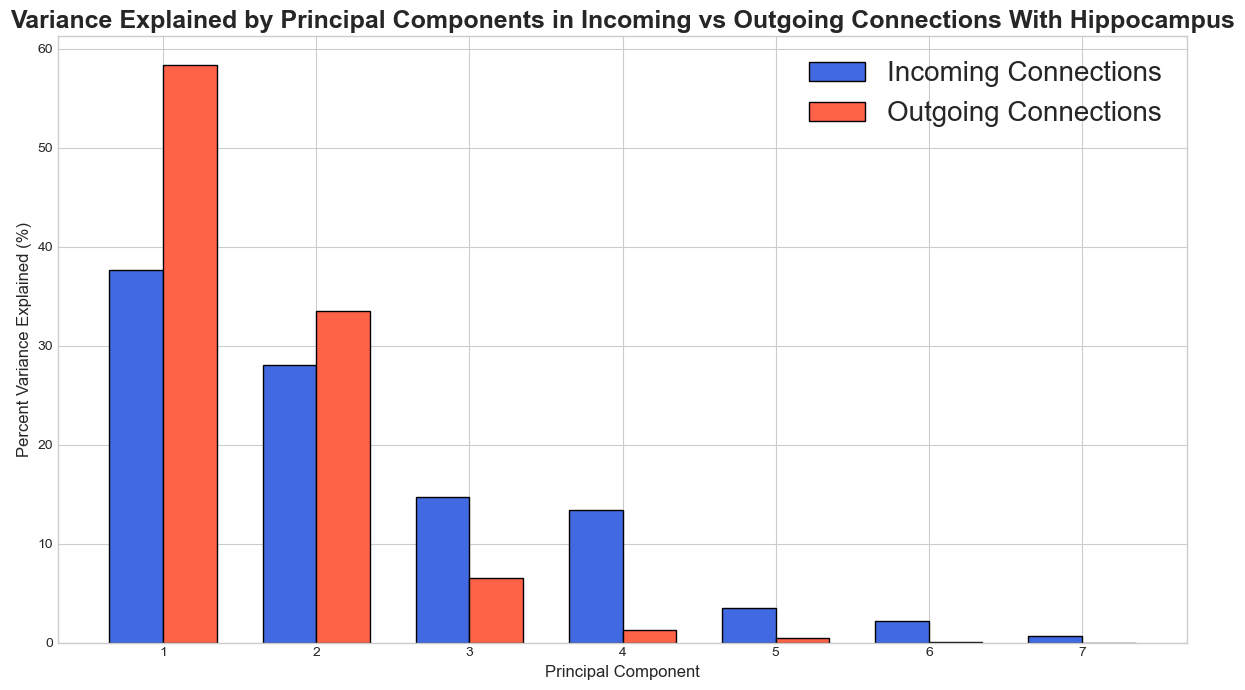

In [5]:
from helpers import plot_incoming_outgoing_PCA

plt_cosine_unique = plot_incoming_outgoing_PCA(incoming_distance = cosine_df_to, 
                                               outgoing_distance = cosine_df_from, 
                                               n_components=7)
plt_cosine_unique.savefig('../output/incoming_outgoing_PCA_cosine_distance_unique_regions.png')

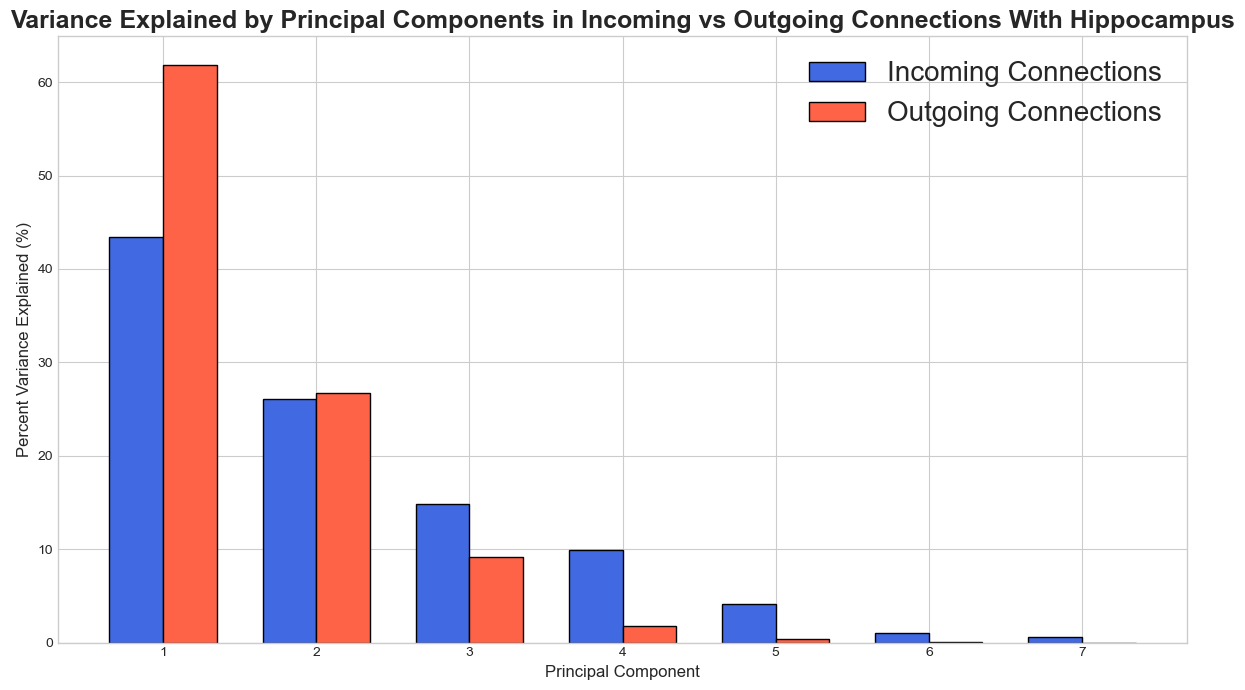

In [7]:
plt_cosine_shared = plot_incoming_outgoing_PCA(incoming_distance = cosine_df_to_shared, 
                                               outgoing_distance = cosine_df_from_shared, 
                                               n_components=7)
plt_cosine_shared.savefig('../output/incoming_outgoing_PCA_cosine_distance_shared_regions.png')

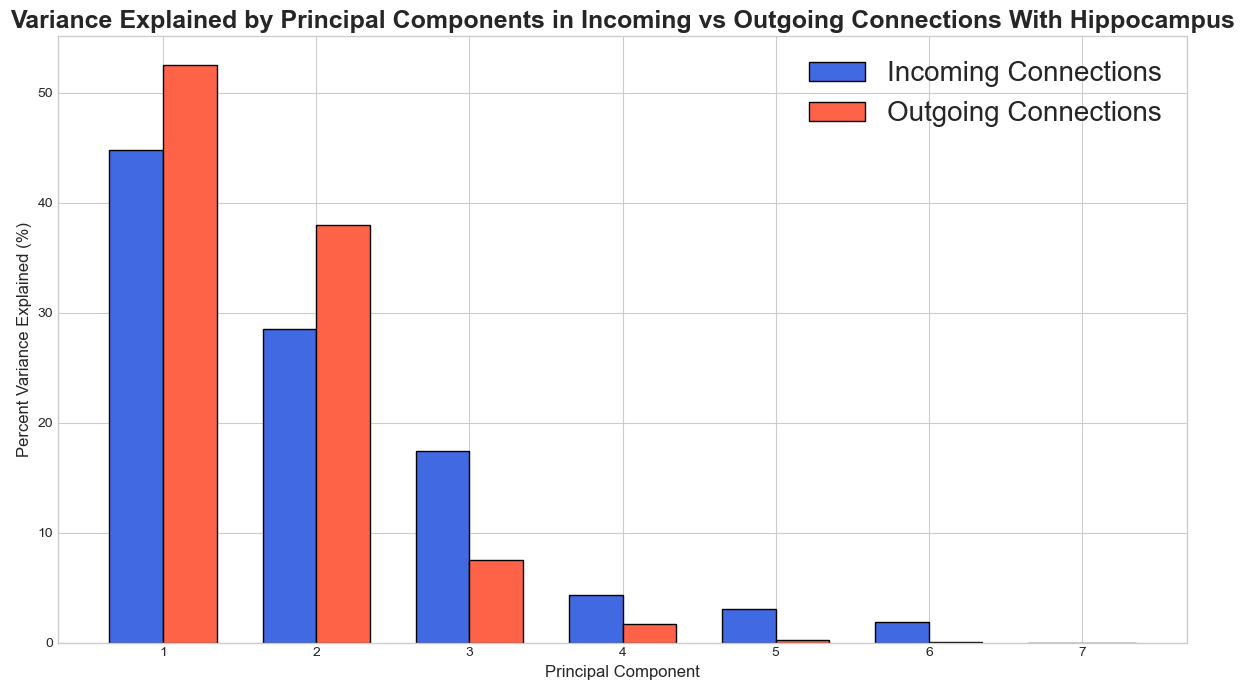

In [8]:
plt_spearman_unique = plot_incoming_outgoing_PCA(incoming_distance = spearman_df_to, 
                                                 outgoing_distance = spearman_df_from, 
                                                 n_components=7)
plt_spearman_unique.savefig('../output/incoming_outgoing_PCA_spearman_unique_regions.png')

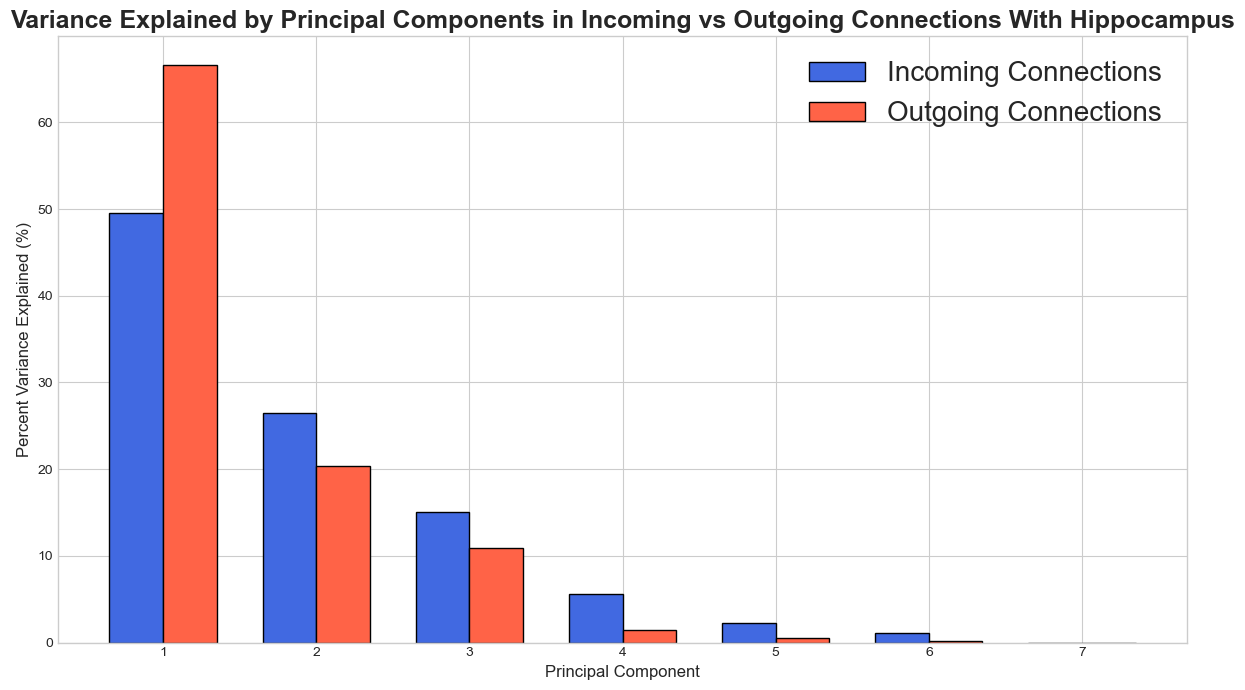

In [9]:
plt_spearman_shared = plot_incoming_outgoing_PCA(incoming_distance = spearman_df_to_shared, 
                                                 outgoing_distance = spearman_df_from_shared, 
                                                 n_components=7)
plt_spearman_shared.savefig('../output/incoming_outgoing_PCA_spearman_shared_regions.png')

# Bootstrapping using Cosine Similarity Matrices

In [20]:
## Helper Function for PCA Differences
def get_pca_variance_diffs(matrix1, matrix2, n_components):
    """
    Runs PCA on two (samples, samples) matrices and returns the
    element-wise difference in their explained variance ratios.
    """
    # CHANGE: We must transpose the matrices to (n_samples, n_features)
    # before fitting them with sklearn's PCA.
    # CHANGE: Sstandardize the data
    scaler = StandardScaler()
    afferent_scaled = scaler.fit_transform(matrix1)
    efferent_scaled = scaler.fit_transform(matrix2)
    
    pca1 = PCA(n_components=n_components, svd_solver='full')
    pca1.fit(afferent_scaled)
    vars1 = pca1.explained_variance_ratio_
    
    pca2 = PCA(n_components=n_components, svd_solver='full')
    pca2.fit(efferent_scaled) # Fit on (N_ROIS, N_FEATURES)
    vars2 = pca2.explained_variance_ratio_
    
    # Return the difference for each component (e.g., [PC1_diff, PC2_diff, ...])
    return vars1 - vars2

In [21]:
# --- CALCULATE PCA DIFFERENCES IN COSINE SIMILARITY OF ACTUAL DATA ---

efferent_vals = df_avg_from_shared.values
cosine_efferent_shared = cosine_similarity(efferent_vals.T)

afferent_vals = df_avg_to_shared.values
cosine_afferent_shared = cosine_similarity(afferent_vals.T)

n_components=7
real_differences = get_pca_variance_diffs(cosine_afferent_shared, 
                                     cosine_efferent_shared,
                                     n_components)

In [22]:
real_differences

array([-0.13289616, -0.05835755,  0.03567832,  0.09271715,  0.0436154 ,
        0.01174983,  0.00749302])

In [23]:
# --- BOOTSTRAP THE CORRELATION MATRICES ----

import random
from helpers import get_correlation_matrix

num_iterations = 2000

wb_variance_explained_afferent = np.zeros((num_iterations, 10))
wb_variance_explained_efferent = np.zeros((num_iterations, 10))
null_distribution = []


# Construct our concatenated matrix of all connections
df_avg_from_shared_renamed = df_avg_from_shared.add_suffix("_efferent")
df_avg_to_shared_renamed = df_avg_to_shared.add_suffix('_afferent')
df_all_connections = pd.concat([df_avg_to_shared_renamed, df_avg_from_shared_renamed], axis=1)

N_FEATURES = len(df_avg_from_shared_renamed.index)
N_ROIS = len(df_avg_from_shared_renamed.columns)

pooled_matrix = df_all_connections.values
total_rois = pooled_matrix.shape[1] # Get total number of columns (ROIs)

for i in range(num_iterations):

    # Shuffle the *rows* of the pooled matrix
    shuffled_indices = np.random.permutation(total_rois)
    shuffled_matrix = pooled_matrix[:, shuffled_indices] # Re-order columns
    
    # Create pseudo-groups by splitting the shuffled data
    # 'pseudo_A' gets the first half, 'pseudo_E' gets the second
    pseudo_A = shuffled_matrix[:, :N_ROIS] # First N_ROIS columns
    pseudo_E = shuffled_matrix[:, N_ROIS:] # Last N_ROIS columns

    # Get cosine similarity matrices for shuffled data
    cosine_values_A = cosine_similarity(pseudo_A.T)
    cosine_values_E = cosine_similarity(pseudo_E.T)
    
    # Perform PCA on Both Datasets
    n_components = 7
    null_diffs = get_pca_variance_diffs(pseudo_A, pseudo_E, n_components)
    
    # Store the result
    null_distribution.append(null_diffs)

In [24]:
# Convert list to a 2D NumPy array for easy analysis
# Shape is (N_PERMUTATIONS, N_COMPONENTS)
null_distribution = np.array(null_distribution)


## 5. Step 4: Analyze Results and Compare
# --- This entire section is identical to before ---
# It just analyzes the final 'null_distribution' array.
print("\n--- Final Analysis ---")

for i in range(7):
    pc_label = f"PC{i+1}"
    real_diff = real_differences[i]
    
    # Get the null distribution for *this specific component*
    null_dist_pc = null_distribution[:, i] # This is a 1D array
    
    # Find the 95% confidence interval
    lower_bound = np.percentile(null_dist_pc, 2.5)
    upper_bound = np.percentile(null_dist_pc, 97.5)
    
    # Calculate a two-tailed p-value
    extreme_count = np.sum(np.abs(null_dist_pc) >= np.abs(real_diff))
    p_value = (extreme_count + 1) / (num_iterations + 1)

    print(f"\n{pc_label} Analysis:")
    print(f"  Real Difference: {real_diff:.4f}")
    print(f"  95% Null Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")
    print(f"  p-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"  Result: SIGNIFICANT. The difference is unlikely due to chance.")
    else:
        print(f"  Result: NOT SIGNIFICANT. The difference is within the range of random chance.")


--- Final Analysis ---

PC1 Analysis:
  Real Difference: -0.1329
  95% Null Interval: [-0.1087, 0.1020]
  p-value: 0.0165
  Result: SIGNIFICANT. The difference is unlikely due to chance.

PC2 Analysis:
  Real Difference: -0.0584
  95% Null Interval: [-0.0557, 0.0564]
  p-value: 0.0390
  Result: SIGNIFICANT. The difference is unlikely due to chance.

PC3 Analysis:
  Real Difference: 0.0357
  95% Null Interval: [-0.0510, 0.0488]
  p-value: 0.1689
  Result: NOT SIGNIFICANT. The difference is within the range of random chance.

PC4 Analysis:
  Real Difference: 0.0927
  95% Null Interval: [-0.0374, 0.0371]
  p-value: 0.0005
  Result: SIGNIFICANT. The difference is unlikely due to chance.

PC5 Analysis:
  Real Difference: 0.0436
  95% Null Interval: [-0.0247, 0.0237]
  p-value: 0.0010
  Result: SIGNIFICANT. The difference is unlikely due to chance.

PC6 Analysis:
  Real Difference: 0.0117
  95% Null Interval: [-0.0261, 0.0247]
  p-value: 0.3643
  Result: NOT SIGNIFICANT. The difference is w